## Import the required modules

In [1]:
from timeit import default_timer
start = default_timer()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Load required files
For first time data load:
1. Load original CSV files.
2. Sort by movieId (main key we'll be using) and reset the indices.
3. Split title and year into separate columns. Convert year to datetime.
4. Categorize genres properly: split strings into boolean columns per genre.
5. Modify the rating timestamp: from universal seconds to datetime year.
6. Check for NaN values. Clean (delete rows) if % of NaN values is small.

In [2]:
def get_months(d, base_year=2000):
    return (d.year - base_year)*12 + d.month
            
st = default_timer()

# First time data load.
#movies = pd.read_csv('../data/ml-20m/movies.csv', sep=',', names = ['movieId','title','genres'], engine='python', skiprows=1)
movies = pd.read_csv('../data/ml-1m/movies.dat', sep='::', names = ['movieId','title','genres'], engine='python')
#ratings = pd.read_csv('../data/ml-20m/ratings.csv', sep=',', names = ['userId','movieId','rating','timestamp'], engine='python', skiprows=1)
ratings = pd.read_csv('../data/ml-1m/ratings.dat', sep='::', names = ['userId','movieId','rating','timestamp'], engine='python')
    
# Organise a bit and store into feather-format
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(ratings.dtypes)

# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

# Categorize movies genres properly.
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
#ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
print(ratings.dtypes)
ratings['timestamp'] = pd.to_datetime(ratings.timestamp, unit='s')
ratings['timestamp'] = ratings['timestamp'].map(get_months)
#ratings.timestamp = str(ratings.timestamp.dt.year)  + '-' + str(ratings.timestamp.dt.month)

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)

print(movies.head())
print(ratings.head())
print('Month of first rating = ', np.min(ratings.timestamp))
print('Month of last rating = ', np.max(ratings.timestamp))
    
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

userId       int64
movieId      int64
rating       int64
timestamp    int64
dtype: object
userId       int64
movieId      int64
rating       int64
timestamp    int64
dtype: object
Number of movies Null values:  0
Number of ratings Null values:  0
   movieId                        title  year  Action  Adventure  Animation  \
0        1                    Toy Story  1995   False      False       True   
1        2                      Jumanji  1995   False       True      False   
2        3             Grumpier Old Men  1995   False      False      False   
3        4            Waiting to Exhale  1995   False      False      False   
4        5  Father of the Bride Part II  1995   False      False      False   

   Children's  Comedy  Crime  Documentary   ...     Fantasy  Film-Noir  \
0        True    True  False        False   ...       False      False   
1        True   False  False        False   ...        True      False   
2       False    True  False        False   ...       Fa

<font color=darkblue>**PLOT#1**: Average rating for all individual movies. <br>

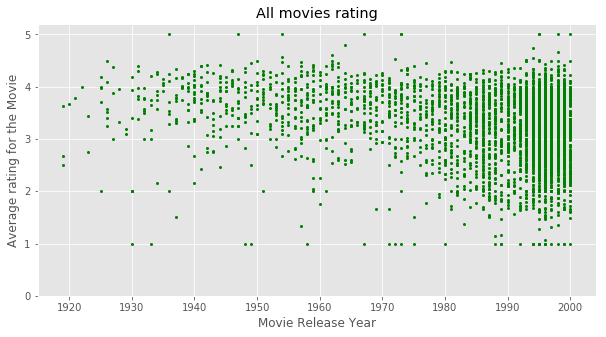

Elapsed time(sec):  0.68


In [3]:
st = default_timer()

dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)
plt.xlabel('Movie Release Year')
plt.ylabel('Average rating for the Movie')
plt.title('All movies rating')
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#2**: Average rating for all movies in each year. <br>
<font color=green>**INSIGHT#2**: Slight decline in average movie ratings after 1960, but still remains above 3. Range quite narrow.</font>

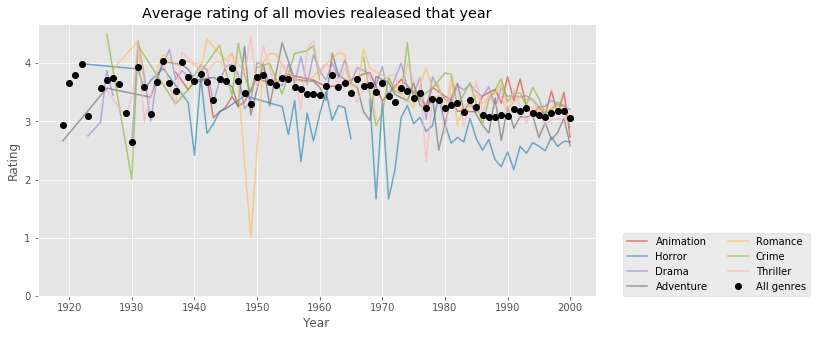

Elapsed time(sec):  1.6


In [4]:
st = default_timer()

plt.figure(figsize=(10,5))
# For each genre
for genre in ['Animation', 'Horror', 'Drama', 'Adventure', 'Romance', 'Crime', 'Thriller']:
    # Select only movies matching current genre. Pick only movieId (as index) and year.
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    # Selects ratings, with movieId as index. Select only movies that match also the previous step. Join both.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    # Now we have a df of movieId, year and multiple ratings. Group by year and compute the average rating.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7)

# For all genres
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='black')

plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating of all movies realeased that year')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#3**: Ratings per user.<br>


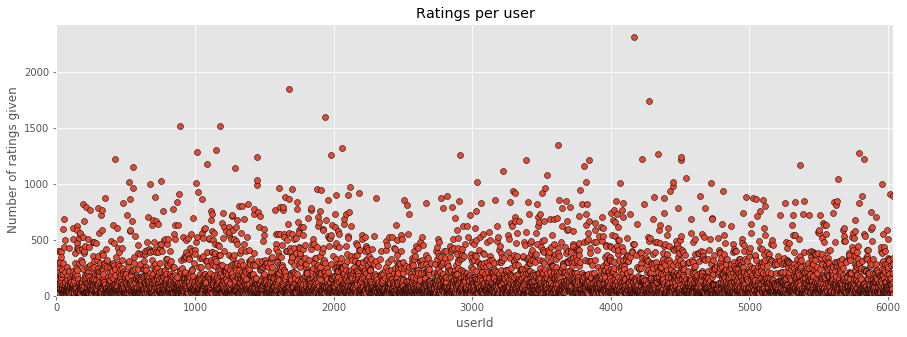

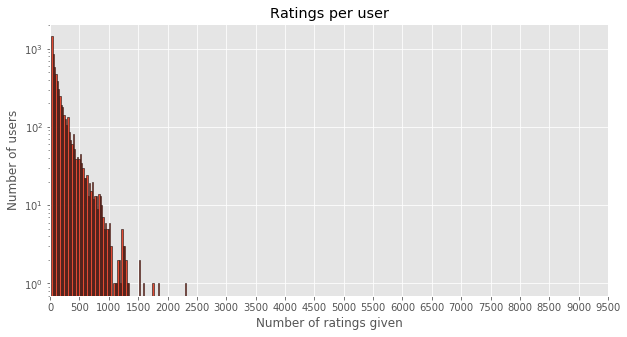

Elapsed time(sec):  1.99


In [5]:
st = default_timer()

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('userId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,len(dftmp.index))
plt.ylim(0,)
plt.title('Ratings per user')
plt.xlabel('userId')
plt.ylabel('Number of ratings given')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(10,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per user')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of users')
plt.xlim(0,)
plt.xticks(np.arange(0,10000,500))
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<font color=darkblue>**PLOT#4**: Ratings per movie.<br>

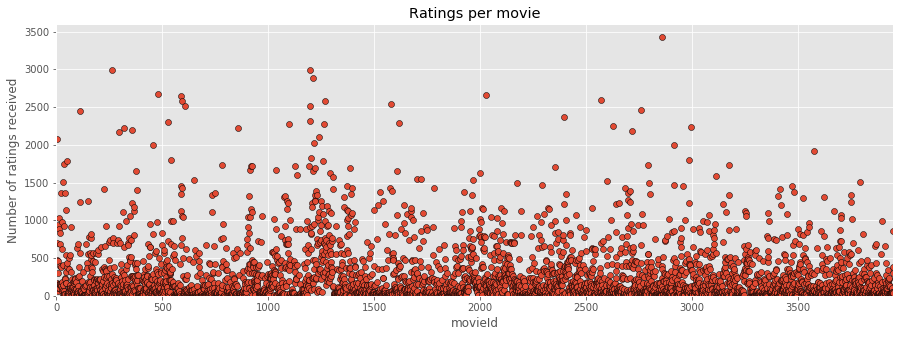

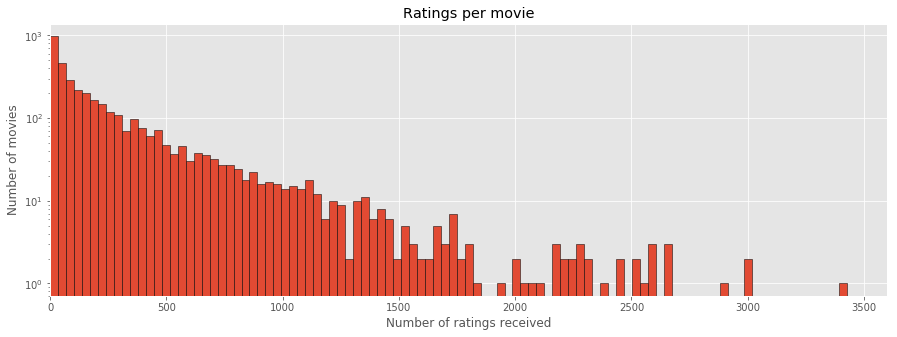

Elapsed time(sec):  1.57


In [6]:
st = default_timer()

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movies')
plt.xlim(0,)
plt.show()



# Housekeeping
%reset_selective -f (^dftmp$|^tmp$|^best$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [7]:
# Now lets try to plot the average rating given by a user per month
#random_user_id = 76
#idx = (ratings['userId'] == random_user_id)
#dftmp = rating
#fig, ax = plt.subplots(figsize=(15,7))s[idx]
#print(dftmp)
grouped = ratings[['rating', 'timestamp']].groupby('timestamp')
#grouped['timestamp']
#s1 = grouped['rating'].mean()
#print(s1)
plt.plot(s1)
plt.show()
#print('eherekjr')
#print(grouped.groups)
#for name,group in grouped:
#    print(name)
#    print(group)
#print('Printing the timestamp column')
#print(dftmp.timestamp)
#plt.figure(figsize=(10,5))
#plt.plot(dftmp['timestamp'], dftmp['rating'],"g.", markersize=4)
#plt.xlabel('Year-Month-Day')
#plt.ylabel('Average rating')
#plt.title('Ratings Trend')
#plt.ylim(0,)
#plt.show()

NameError: name 's1' is not defined